In [1]:
# Run this cell only if tensorflow 2.0 needs to be installed, otherwise please ignore this cell

#!pip install tensorflow-gpu==2.0.0-beta1

In [2]:
# Importing the libraries
import numpy
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import tensorflow as tf
tf.compat.v1.random.set_random_seed(37)

/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/heisenberg/.local/lib/python3.5/site-packages/tensorflow/python/framework

In [4]:
# Mini Batch Optimizer
def minibatch_gradient_descent(W,del_W,lr):
  new_W = W - lr * del_W
  return new_W

In [5]:
# Nesterov's Accelerated Gradient Optimizer
def nesterov_accelerated_gradient(W,del_W,lr,gamma,old_update):
  old_update = gamma * old_update + lr * del_W
  new_W = W - old_update
  return new_W, old_update

In [6]:
# Adagrad Optimizer
def myAdagrad(W,del_W,lr,vt,epsilon):
  vt = vt + (tf.square(del_W))
  new_W = W - tf.multiply(lr / (tf.sqrt(vt + epsilon)),del_W)
  return new_W, vt

In [7]:
# RMSProp Optimizer
def my_rmsprop(W,del_W,lr,vt,epsilon,beta):
  vt = beta * vt + (1-beta) * (tf.square(del_W))
  new_W = W - tf.multiply(lr / (tf.sqrt(vt + epsilon)),del_W)
  return new_W, vt

In [8]:
# Adam Optimizer
def myAdam(W,del_W,lr,mt,vt,epsilon,beta,gamma,t):
  mt = gamma + mt + (1-gamma) * del_W
  vt = beta * vt + (1-beta) * (tf.square(del_W))
  mt_rec = mt / (1 - gamma**t)
  vt_rec = vt / (1 - beta**t)
  #new_W = W - lr * mt
  new_W = W - tf.multiply(lr / (tf.sqrt(vt_rec + epsilon)),mt_rec)
  return new_W, vt,mt

In [9]:
# Function to iterate over the loss. Here, the loss is the convex loss as given in the question
def itr_loss1(lr,a,b,c,W,insignificant_Z,descent_option):
  
  Z = (a[0]*((W[0]-b[0])**2)) + (a[1]*((W[1]-b[1])**2)) + c
  Z = tf.convert_to_tensor(Z,dtype=tf.float32); new_Z = Z

  i = 0; list_Zval = []; list_W1val = []; list_W2val = []; gamma = 0.9; epsilon = 0.5; beta = 0.9
  old_update = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)
  vt = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)
  mt = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)

  list_Zval.append(new_Z.numpy())
  list_W1val.append(W.numpy()[0])
  list_W2val.append(W.numpy()[1])
    
  flag = True
  while flag==True:

    # For mini-Batch Gradient Descent
    if descent_option == 1:
      del_W1 = 2*a[0]*(W[0]-b[0]); del_W2 = 2*a[1]*(W[1]-b[1])
      del_W = tf.stack([del_W1, del_W2])
      W = minibatch_gradient_descent(W,del_W,lr)
    
    # For Nesterov's Accelerated Gradient Descent
    if descent_option == 2:
      W_lookahead = W - gamma * old_update
      del_W1 = 2*a[0]*(W_lookahead[0]-b[0]); del_W2 = 2*a[1]*(W_lookahead[1]-b[1])
      del_W = tf.stack([del_W1, del_W2])
      W,old_update = nesterov_accelerated_gradient(W,del_W,lr,gamma,old_update)

    # For AdaGrad
    if descent_option == 3:
      del_W1 = 2*a[0]*(W[0]-b[0]); del_W2 = 2*a[1]*(W[1]-b[1])
      del_W = tf.stack([del_W1, del_W2])
      W,vt = myAdagrad(W,del_W,lr,vt,epsilon)
    
    # For RMSProp
    if descent_option == 4:
      del_W1 = 2*a[0]*(W[0]-b[0]); del_W2 = 2*a[1]*(W[1]-b[1])
      del_W = tf.stack([del_W1, del_W2])
      W,vt = my_rmsprop(W,del_W,lr,vt,epsilon,beta)

    # For Adam
    if descent_option == 5:
      del_W1 = 2*a[0]*(W[0]-b[0]); del_W2 = 2*a[1]*(W[1]-b[1])
      del_W = tf.stack([del_W1, del_W2])
      W,vt,mt = myAdam(W,del_W,lr,mt,vt,epsilon,beta,gamma,i+1)
    
    new_Z = (a[0]*((W[0]-b[0])**2)) + (a[1]*((W[1]-b[1])**2)) + c

    #print(i,new_Z.numpy()-insignificant_Z.numpy(),W.numpy())
    
    i += 1

    list_Zval.append(new_Z.numpy())
    list_W1val.append(W.numpy()[0])
    list_W2val.append(W.numpy()[1])
    
    if new_Z.numpy()<insignificant_Z.numpy() or i>1000: flag=False
  
  return list_Zval, list_W1val, list_W2val

Mini Batch Gradient Descent
Nesterovs Accelerated Gradient
AdaGrad
RMSProp
Adam


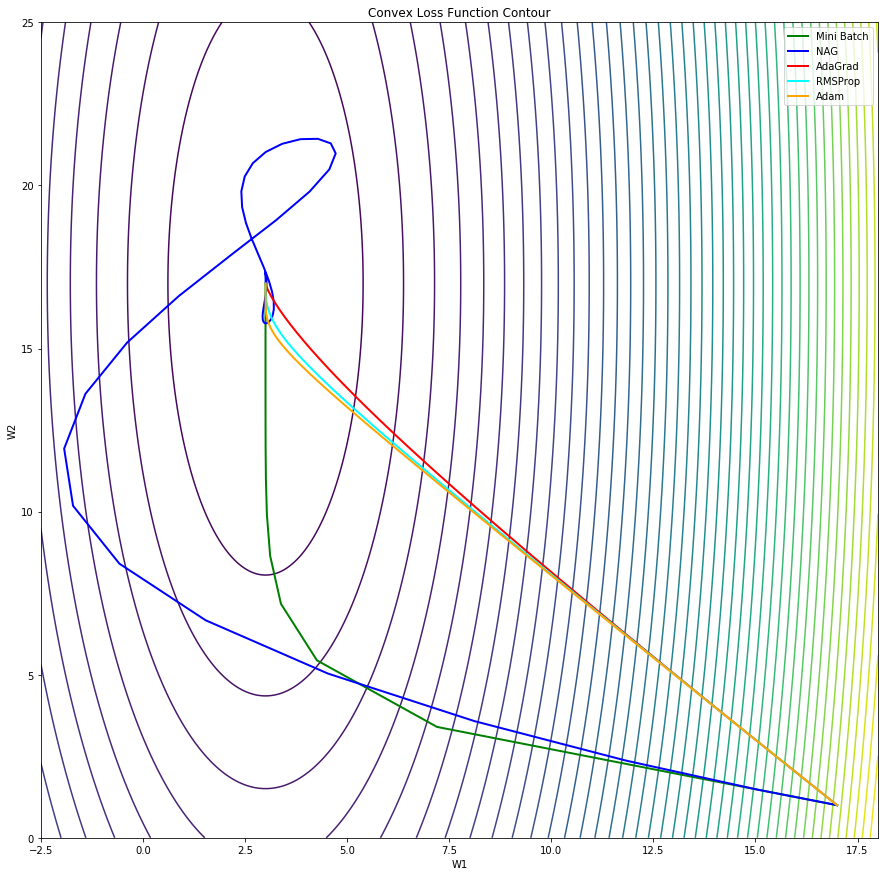

In [10]:
# Loss Function 1: Calling Convex Function for Each Optimizer

# Create Grid
num = 1000
x1 = numpy.linspace(-2.5,18,num,endpoint=True)
x2 = numpy.linspace(-0,25,num,endpoint=True)
W1, W2 = numpy.meshgrid(x1,x2)

a1 = 7; a2 = 1.5; b1 = 3; b2 = 17; c = 1e-6
Z = (a1*((W1-b1)**2)) + (a2*((W2-b2)**2)) + c

# Initialize

insignificant_Z = 1e-4
insignificant_Z = tf.convert_to_tensor(insignificant_Z,dtype=tf.float32)


a1 = tf.convert_to_tensor(a1,dtype=tf.float32); a2 = tf.convert_to_tensor(a2,dtype=tf.float32)
b1 = tf.convert_to_tensor(b1,dtype=tf.float32); b2 = tf.convert_to_tensor(b2,dtype=tf.float32)
c = tf.convert_to_tensor(c,dtype=tf.float32)

W1 = tf.convert_to_tensor(17,dtype=tf.float32); W2 = tf.convert_to_tensor(1,dtype=tf.float32)

a = tf.stack([a1, a2]); b = tf.stack([b1, b2]); W = tf.stack([W1, W2]); 

print('Mini Batch Gradient Descent')
lr = 5e-2; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_mini_gd, w1list_mini_gd, w2list_mini_gd = itr_loss1(lr,a,b,c,W,insignificant_Z,descent_option=1)

print('Nesterovs Accelerated Gradient')
lr = 1e-2; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_nag, w1list_nag, w2list_nag = itr_loss1(lr,a,b,c,W,insignificant_Z,descent_option=2)

print('AdaGrad')
lr = 9e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_adagrad, w1list_adagrad, w2list_adagrad = itr_loss1(lr,a,b,c,W,insignificant_Z,descent_option=3)

print('RMSProp')
lr = 1e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_rmsprop, w1list_rmsprop, w2list_rmsprop = itr_loss1(lr,a,b,c,W,insignificant_Z,descent_option=4)

print('Adam')
lr = 5e-2; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_adam, w1list_adam, w2list_adam = itr_loss1(lr,a,b,c,W,insignificant_Z,descent_option=4)

# Grid for Plot
num = 1000
x1 = numpy.linspace(-2.5,18,num,endpoint=True)
x2 = numpy.linspace(-0,25,num,endpoint=True)
W1, W2 = numpy.meshgrid(x1,x2)

a1 = 7; a2 = 0.5; b1 = 3; b2 = 17; c = 1e-6

Z = (a1*((W1-b1)**2)) + (a2*((W2-b2)**2)) + c

# Plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot()
ax.contour(W1,W2,Z,levels=50)
ax.plot(w1list_mini_gd,w2list_mini_gd, color='green',linewidth=2.0,label='Mini Batch')
ax.plot(w1list_nag,w2list_nag, color='blue',linewidth=2.0,label='NAG')
ax.plot(w1list_adagrad,w2list_adagrad, color='red',linewidth=2.0,label='AdaGrad')
ax.plot(w1list_rmsprop,w2list_rmsprop, color='cyan',linewidth=2.0,label='RMSProp')
ax.plot(w1list_adam,w2list_adam, color='orange',linewidth=2.0,label='Adam')
ax.legend(loc=1)
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_title('Convex Loss Function Contour')
plt.show()


In [11]:
# Function to iterate over the loss. Here, the loss is long valley, that is X^2-y^2.
# Typically this loss function is used to check for saddle point.
def itr_loss2(lr,W,insignificant_Z,descent_option):
  
  Z = tf.square(W[0]) - tf.square(W[1])
  Z = tf.convert_to_tensor(Z,dtype=tf.float32); new_Z = Z

  i = 0; list_Zval = []; list_W1val = []; list_W2val = []; gamma = 0.9; epsilon = 0.5; beta = 0.9
  old_update = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)
  vt = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)
  mt = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)

  list_Zval.append(new_Z.numpy())
  list_W1val.append(W.numpy()[0])
  list_W2val.append(W.numpy()[1])

  flag= True
  while flag==True:

    # For mini-Batch Gradient Descent
    if descent_option == 1:
      del_W1 = 2*W[0]; del_W2 = 2*W[1]
      del_W = tf.stack([del_W1, del_W2])
      W = minibatch_gradient_descent(W,del_W,lr)
    
    # For Nesterov's Accelerated Gradient Descent
    if descent_option == 2:
      W_lookahead = W - gamma * old_update
      del_W1 = 2*W_lookahead[0]; del_W2 = W_lookahead[1]
      del_W = tf.stack([del_W1, del_W2])
      W,old_update = nesterov_accelerated_gradient(W,del_W,lr,gamma,old_update)

    # For AdaGrad
    if descent_option == 3:
      del_W1 = 2*W[0]; del_W2 = 2*W[1]
      del_W = tf.stack([del_W1, del_W2])
      W,vt = myAdagrad(W,del_W,lr,vt,epsilon)
    
    # For RMSProp
    if descent_option == 4:
      del_W1 = 2*W[0]; del_W2 = 2*W[1]
      del_W = tf.stack([del_W1, del_W2])
      W,vt = my_rmsprop(W,del_W,lr,vt,epsilon,beta)

    # For Adam
    if descent_option == 5:
      del_W1 = 2*W[0]; del_W2 = 2*W[1]
      del_W = tf.stack([del_W1, del_W2])
      W,vt,mt = myAdam(W,del_W,lr,mt,vt,epsilon,beta,gamma,i+1)
    
    new_Z = tf.square(W[0]) - tf.square(W[1])

    #print(i,new_Z.numpy()-insignificant_Z.numpy(),W.numpy())
    
    i += 1

    list_Zval.append(new_Z.numpy())
    list_W1val.append(W.numpy()[0])
    list_W2val.append(W.numpy()[1])
    
    if new_Z.numpy()<insignificant_Z.numpy() or i>2000: flag=False
  
  return list_Zval, list_W1val, list_W2val

Mini Batch Gradient Descent
Nesterovs Accelerated Gradient
AdaGrad
RMSProp
Adam


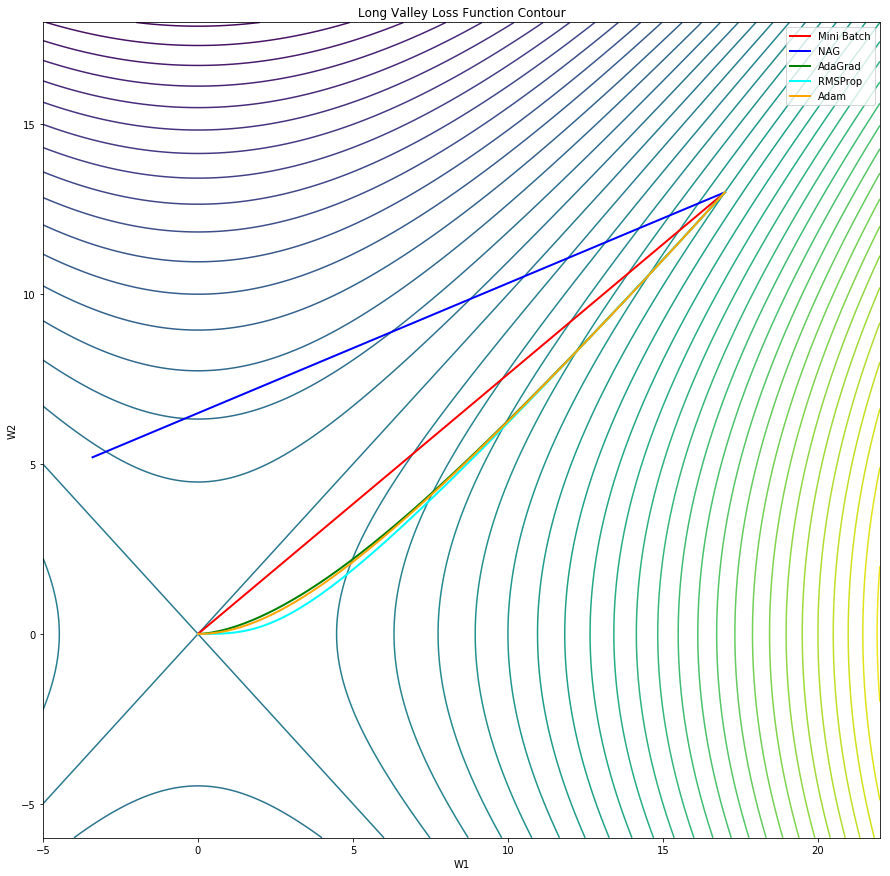

In [12]:
# Loss Function 2: Calling Long Valley for Each Optimizer

# Create Grid
num = 1000
x1 = numpy.linspace(-5,22,num,endpoint=True)
x2 = numpy.linspace(-6,18,num,endpoint=True)
W1, W2 = numpy.meshgrid(x1,x2)

Z = (W1**2)-(W2**2)

insignificant_Z = 1e-4
insignificant_Z = tf.convert_to_tensor(insignificant_Z,dtype=tf.float32)

W1 = tf.convert_to_tensor(17,dtype=tf.float32); W2 = tf.convert_to_tensor(13,dtype=tf.float32)

W = tf.stack([W1, W2]); 

print('Mini Batch Gradient Descent')
lr = 1e-2; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_mini_gd, w1list_mini_gd, w2list_mini_gd = itr_loss2(lr,W,insignificant_Z,descent_option=1)

print('Nesterovs Accelerated Gradient')
lr = 6e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_nag, w1list_nag, w2list_nag = itr_loss2(lr,W,insignificant_Z,descent_option=2)

print('AdaGrad')
lr = 8e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_adagrad, w1list_adagrad, w2list_adagrad = itr_loss2(lr,W,insignificant_Z,descent_option=3)

print('RMSProp')
lr = 2e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_rmsprop, w1list_rmsprop, w2list_rmsprop = itr_loss2(lr,W,insignificant_Z,descent_option=4)

print('Adam')
lr = 5e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_adam, w1list_adam, w2list_adam = itr_loss2(lr,W,insignificant_Z,descent_option=4)

# Grid for Plot
num = 1000
x1 = numpy.linspace(-5,22,num,endpoint=True)
x2 = numpy.linspace(-6,18,num,endpoint=True)
W1, W2 = numpy.meshgrid(x1,x2)

Z = (W1**2)-(W2**2)

# Plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot()
ax.contour(W1,W2,Z,levels=50)
ax.plot(w1list_mini_gd,w2list_mini_gd, color='red',linewidth=2.0,label='Mini Batch')
ax.plot(w1list_nag,w2list_nag, color='blue',linewidth=2.0,label='NAG')
ax.plot(w1list_adagrad,w2list_adagrad, color='green',linewidth=2.0,label='AdaGrad')
ax.plot(w1list_rmsprop,w2list_rmsprop, color='cyan',linewidth=2.0,label='RMSProp')
ax.plot(w1list_adam,w2list_adam, color='orange',linewidth=2.0,label='Adam')
ax.legend(loc=1)
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_title('Long Valley Loss Function Contour')
plt.show()


In [13]:
# Using Gradient Tape to calculate gradient for Beale's Function
def getGrad(W):
  #W = tf.Variable(W)
  with tf.GradientTape(persistent=True) as g:
    g.watch(W)
    Z = ((1.5-W[0]+W[0]*W[1])**2) + ((2.25-W[0]+W[0]*W[1]**2)**2) + ((2.625-W[0]+W[0]*W[1]**3)**2)
  del_W = g.gradient(Z, W)
  del g
  return(del_W)

In [14]:
# Function to iterate over the loss. Here, the loss is Beale's Function.
def itr_loss3(lr,W,insignificant_Z,descent_option):
  
  Z = ((1.5-W[0]+W[0]*W[1])**2) + ((2.25-W[0]+W[0]*W[1]**2)**2) + ((2.625-W[0]+W[0]*W[1]**3)**2)
  Z = tf.convert_to_tensor(Z,dtype=tf.float32); new_Z = Z

  i = 0; list_Zval = []; list_W1val = []; list_W2val = []; gamma = 0.9; epsilon = 0.5; beta = 0.9
  old_update = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)
  vt = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)
  mt = tf.convert_to_tensor([0.0,0.0],dtype=tf.float32)

  list_Zval.append(new_Z.numpy())
  list_W1val.append(W.numpy()[0])
  list_W2val.append(W.numpy()[1])

  flag = True
  while flag==True:

    # For mini-Batch Gradient Descent
    if descent_option == 1:
      del_W = getGrad(W)
      W = minibatch_gradient_descent(W,del_W,lr)
    
    # For Nesterov's Accelerated Gradient Descent
    if descent_option == 2:
      W_lookahead = W - gamma * old_update
      del_W = getGrad(W_lookahead)
      W,old_update = nesterov_accelerated_gradient(W,del_W,lr,gamma,old_update)

    # For AdaGrad
    if descent_option == 3:
      del_W = getGrad(W)
      W,vt = myAdagrad(W,del_W,lr,vt,epsilon)
    
    # For RMSProp
    if descent_option == 4:
      del_W = getGrad(W)
      W,vt = my_rmsprop(W,del_W,lr,vt,epsilon,beta)

    # For Adam
    if descent_option == 5:
      del_W = getGrad(W)
      W,vt,mt = myAdam(W,del_W,lr,mt,vt,epsilon,beta,gamma,i+1)
    
    new_Z = tf.square(W[0]) - tf.square(W[1])

    #print(i,new_Z.numpy()-insignificant_Z.numpy(),W.numpy())
    
    i += 1

    list_Zval.append(new_Z.numpy())
    list_W1val.append(W.numpy()[0])
    list_W2val.append(W.numpy()[1])
    
    if new_Z.numpy()<insignificant_Z.numpy() or i>1000: flag=False
  
  return list_Zval, list_W1val, list_W2val

Mini Batch Gradient Descent
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Nesterovs Accelerated Gradient
AdaGrad
RMSProp
Adam


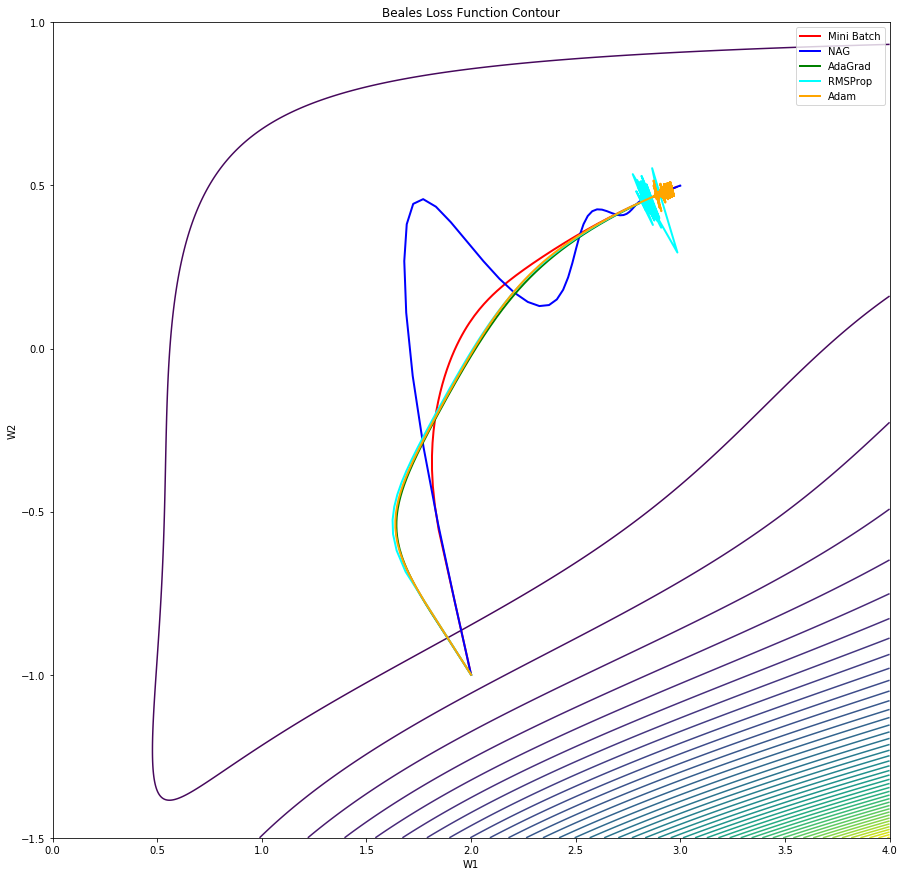

In [15]:
# Loss Function 3: Calling Beale's Function for Each Optimizer

# Create Grid
num = 2000
x1 = numpy.linspace(0,4,num,endpoint=True)
x2 = numpy.linspace(-1.5,1,num,endpoint=True)
W1, W2 = numpy.meshgrid(x1,x2)

Z = ((1.5-W1+W1*W2)**2) + ((2.25-W1+W1*W2**2)**2) + ((2.625-W1+W1*W2**3)**2)

insignificant_Z = 1e-4
insignificant_Z = tf.convert_to_tensor(insignificant_Z,dtype=tf.float32)

W1 = tf.convert_to_tensor(2,dtype=tf.float32); W2 = tf.convert_to_tensor(-1,dtype=tf.float32)
W = tf.stack([W1, W2]);

print('Mini Batch Gradient Descent')
lr = 1e-2; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_mini_gd, w1list_mini_gd, w2list_mini_gd = itr_loss3(lr,W,insignificant_Z,descent_option=1)

print('Nesterovs Accelerated Gradient')
lr = 5e-3; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_nag, w1list_nag, w2list_nag = itr_loss3(lr,W,insignificant_Z,descent_option=2)

print('AdaGrad')
lr = 1e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_adagrad, w1list_adagrad, w2list_adagrad = itr_loss3(lr,W,insignificant_Z,descent_option=3)

print('RMSProp')
lr = 1e-1; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_rmsprop, w1list_rmsprop, w2list_rmsprop = itr_loss3(lr,W,insignificant_Z,descent_option=4)

print('Adam')
lr = 5e-2; lr = tf.convert_to_tensor(lr,dtype=tf.float32)
zlist_adam, w1list_adam, w2list_adam = itr_loss3(lr,W,insignificant_Z,descent_option=4)

# Grid for Plot
num = 1000
x1 = numpy.linspace(0,4,num,endpoint=True)
x2 = numpy.linspace(-1.5,1,num,endpoint=True)
W1, W2 = numpy.meshgrid(x1,x2)

Z = ((1.5-W1+W1*W2)**2) + ((2.25-W1+W1*W2**2)**2) + ((2.625-W1+W1*W2**3)**2)

# Plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot()
ax.contour(W1,W2,Z,levels=50)
ax.plot(w1list_mini_gd,w2list_mini_gd, color='red',linewidth=2.0,label='Mini Batch')
ax.plot(w1list_nag,w2list_nag, color='blue',linewidth=2.0,label='NAG')
ax.plot(w1list_adagrad,w2list_adagrad, color='green',linewidth=2.0,label='AdaGrad')
ax.plot(w1list_rmsprop,w2list_rmsprop, color='cyan',linewidth=2.0,label='RMSProp')
ax.plot(w1list_adam,w2list_adam, color='orange',linewidth=2.0,label='Adam')
ax.legend(loc=1)
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_title('Beales Loss Function Contour')
plt.show()
